Determining the demographics of 12 SMD in Portland, OR using 2020 Census.

In [ ]:
import matplotlib.pyplot as plt
from gerrychain import (Partition, Graph, MarkovChain,
                        updaters, accept)
from gerrychain.proposals import recom
from gerrychain.constraints import contiguous
from gerrychain.optimization import SingleMetricOptimizer, Gingleator
from functools import partial
import pandas
import geopandas as gpd
from pcompress import Record, Replay
import networkx as nx
import maup
import json
import numpy as np

# Set the random seed so that the results are reproducible!
import random
random.seed(2024)

# Chain

In [60]:
atomic_units = gpd.read_file("../Shapefiles/Portland blocks with pop/Portland_blocks_with_pop.shp")
atomic_units.rename(columns={c:c if "DVAP" not in c else "C".join(c.split("D")) for c in atomic_units.columns}, inplace=True)
n_districts = 12

tot_pop_col = "TOTPOP20"
tot_cvap_col = "CVAP22"
bcvap_col = "BCVAP22"
amincvap_col = "AMINCVAP22"
hcvap_col = "HCVAP22"
aapicvap_col = "AAPICVAP22"
wcvap_col = "WCVAP22"
poc_cvap_col = "POCCVAP22"

demo_cols = [tot_pop_col, tot_cvap_col,
             bcvap_col, amincvap_col, wcvap_col, hcvap_col, aapicvap_col,
             ]

poc_cols = [bcvap_col, amincvap_col, hcvap_col, aapicvap_col,]

atomic_units[poc_cvap_col] = sum(atomic_units[c] for c in poc_cols)


epsilon = .05
n_steps = 100000
opt_n_steps = 1000000
burst_size = 10
file_name = f"portland_{n_districts}_n_districts_{epsilon}_epsilon_{n_steps}_n_steps"
opt_file_name = f"portland_{n_districts}_n_districts_{epsilon}_epsilon_{opt_n_steps}_n_steps_short_burst_{burst_size}"


In [51]:
atomic_units = atomic_units[atomic_units["GEOID20"] != "410050222064007"] # drop an island with 0 pop

## Connecting dual graph

In [52]:
graph = Graph.from_geodataframe(atomic_units)

island_1 = "410050222064003"
new_connections_1 = [ "410510089022016", "410050222064009", "410510089022015", "410510089022013"]

island_2 = "410510086002017"
new_connections_2 = ["410510086002027", "410510086002016", "410510086002028"]

def find_node_by_geoid(geoid, graph=graph):
    for node in graph:
        if graph.nodes[node]["GEOID20"] == geoid:
            return node
        
island_1_node = find_node_by_geoid(island_1)
island_2_node = find_node_by_geoid(island_2)

island_1_connections = [find_node_by_geoid(x) for x in new_connections_1]
island_2_connections = [find_node_by_geoid(x) for x in new_connections_2]

for n in island_1_connections:
    graph.add_edge(island_1_node, n)

for n in island_2_connections:
    graph.add_edge(island_2_node, n)

graph = nx.convert_node_labels_to_integers(graph, first_label=0)

/Users/cdonnay/Documents/GitHub/MGGG/Portland-Postmortem/.venv/lib/python3.10/site-packages/gerrychain/graph/graph.py:406: UserWarning: Found islands (degree-0 nodes). Indices of islands: {5554, 4454}
  warnings.warn(


In [53]:
my_updaters = {
    "cut_edges": updaters.cut_edges
}
my_updaters.update({col: updaters.Tally(col) for col in demo_cols+[poc_cvap_col]})

initial_partition = Partition.from_random_assignment(
    graph,
    n_districts,
    updaters=my_updaters,
    pop_col=tot_pop_col,
    epsilon=epsilon
)

In [54]:
ideal_population = sum(initial_partition[tot_pop_col].values()) / len(initial_partition)

proposal = partial(
    recom,
    pop_col=tot_pop_col,
    pop_target=ideal_population,
    epsilon=epsilon,
    node_repeats=2
)

recom_chain = MarkovChain(
    proposal=proposal,
    constraints=[contiguous],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=n_steps
)

In [8]:
for i, partition in enumerate(Record(recom_chain, f"{file_name}.chain")):
    if i%(n_steps/100) == 0:
        print(f"{i/n_steps:.0%}")

0%
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%


In [66]:
gingles = Gingleator(
    proposal,
    constraints=[contiguous],
    initial_state=initial_partition,
    minority_pop_col=poc_cvap_col,
    total_pop_col=tot_cvap_col,
    score_function=Gingleator.reward_partial_dist
)

for i, partition in enumerate(Record(gingles.short_bursts(burst_size, int(opt_n_steps/burst_size)), f"{opt_file_name}.chain")):
    if i%(opt_n_steps/100) == 0:
        print(f"{i/opt_n_steps:.0%}")

print(gingles.best_score)


0%
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%


/Users/cdonnay/Documents/GitHub/MGGG/Portland-Postmortem/.venv/lib/python3.10/site-packages/gerrychain/tree.py:704: BipartitionWarning: 
Failed to find a balanced cut after 1000 attempts.
If possible, consider enabling pair reselection within your
MarkovChain proposal method to allow the algorithm to select
a different pair of districts for recombination.
  warnings.warn(


50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%


/Users/cdonnay/Documents/GitHub/MGGG/Portland-Postmortem/.venv/lib/python3.10/site-packages/gerrychain/tree.py:704: BipartitionWarning: 
Failed to find a balanced cut after 1000 attempts.
If possible, consider enabling pair reselection within your
MarkovChain proposal method to allow the algorithm to select
a different pair of districts for recombination.
  warnings.warn(


87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%
0.4365253814588877


## Viz

In [ ]:
poc_cvap_df = pandas.DataFrame(
    sorted([poc_cvap/partition[tot_cvap_col][district] for district, poc_cvap in partition[poc_cvap_col].items()])
    for partition in Replay(graph, f"{file_name}.chain", my_updaters)
)

/Users/cdonnay/Documents/GitHub/MGGG/Portland-Postmortem/.venv/lib/python3.10/site-packages/pandas/core/frame.py:843: ResourceWarning: unclosed file <_io.BufferedReader name=75>
  data = list(data)


/var/folders/r_/xjlnv23j48v1p28d0tq18wcc0000gn/T/ipykernel_1257/76050943.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{x:.1%}" for x in np.arange(.22,.29,.01)])


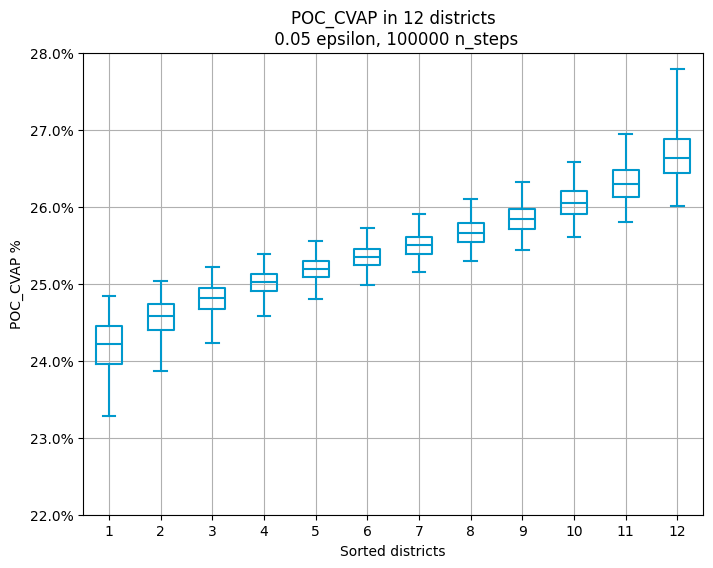

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")
boxstyle = {
        "lw": 1.5 ,
        "color": "#0099cd",
    }
# Draw boxplot
poc_cvap_df.boxplot(ax=ax, 
           positions=range(len(poc_cvap_df.columns)),  
           whis=(1,99),
        boxprops=boxstyle,
        whiskerprops=boxstyle,
        capprops=boxstyle,
        medianprops=boxstyle,
        showfliers=False,)

# Annotate
ax.set_title(f"POC_CVAP in {n_districts} districts\n {epsilon} epsilon, {n_steps} n_steps")
ax.set_ylabel("POC_CVAP %")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0.22,.28)
ax.set_yticklabels([f"{x:.1%}" for x in np.arange(.22,.29,.01)])
ax.set_xticklabels([x for x in range(1,n_districts+1)])


plt.show()



In [25]:
b_cvap_df = pandas.DataFrame(
    sorted([b_cvap/partition[tot_cvap_col][district] for district, b_cvap in partition[bcvap_col].items()])
    for partition in Replay(graph, f"{file_name}.chain", my_updaters)
)

/Users/cdonnay/Documents/GitHub/MGGG/Portland-Postmortem/.venv/lib/python3.10/site-packages/pandas/core/frame.py:843: ResourceWarning: unclosed file <_io.BufferedReader name=76>
  data = list(data)


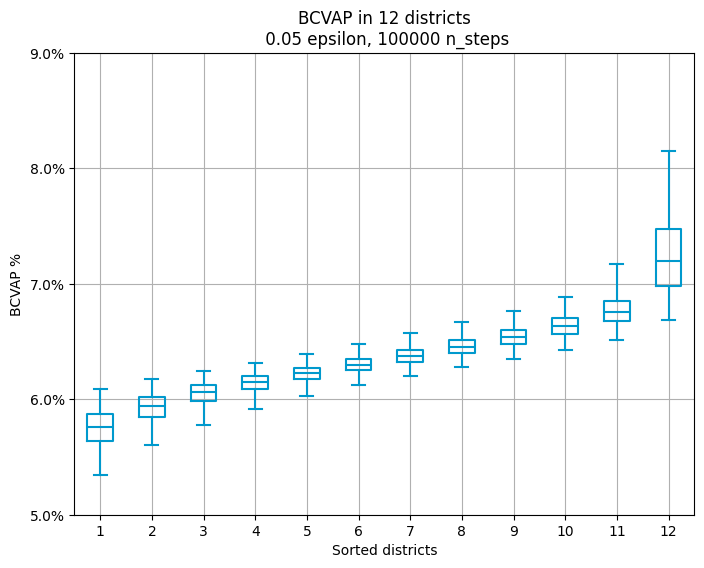

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")
boxstyle = {
        "lw": 1.5 ,
        "color": "#0099cd",
    }
# Draw boxplot
b_cvap_df.boxplot(ax=ax, 
           positions=range(len(b_cvap_df.columns)),  
           whis=(1,99),
        boxprops=boxstyle,
        whiskerprops=boxstyle,
        capprops=boxstyle,
        medianprops=boxstyle,
        showfliers=False,)

# Annotate
ax.set_title(f"BCVAP in {n_districts} districts\n {epsilon} epsilon, {n_steps} n_steps")
ax.set_ylabel("BCVAP %")
ax.set_xlabel("Sorted districts")
y_min = .05
y_max = .09
ax.set_ylim(y_min,y_max)
ax.set_yticks([x for x in np.arange(y_min,y_max + .01,.01)])
ax.set_yticklabels([f"{x:.1%}" for x in np.arange(y_min,y_max+.01,.01)])
ax.set_xticklabels([x for x in range(1,n_districts+1)])


plt.show()

In [27]:
h_cvap_df = pandas.DataFrame(
    sorted([h_cvap/partition[tot_cvap_col][district] for district, h_cvap in partition[hcvap_col].items()])
    for partition in Replay(graph, f"{file_name}.chain", my_updaters)
)

/Users/cdonnay/Documents/GitHub/MGGG/Portland-Postmortem/.venv/lib/python3.10/site-packages/pandas/core/frame.py:843: ResourceWarning: unclosed file <_io.BufferedReader name=92>
  data = list(data)


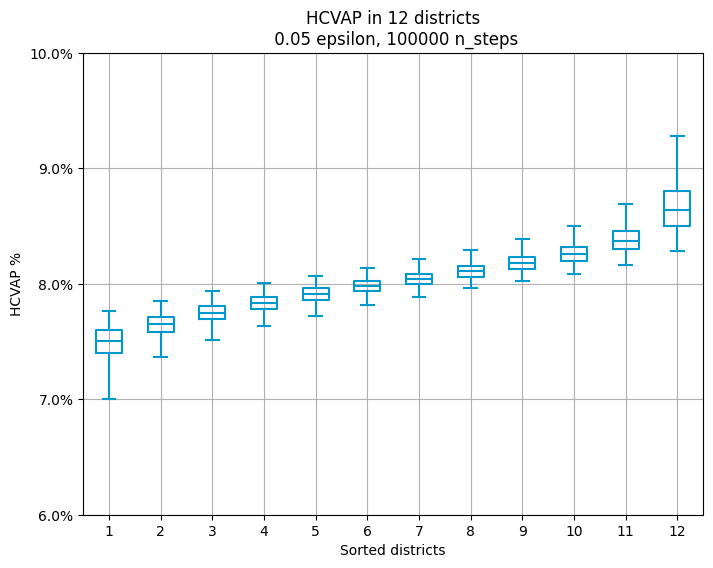

In [48]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")
boxstyle = {
        "lw": 1.5 ,
        "color": "#0099cd",
    }
# Draw boxplot
h_cvap_df.boxplot(ax=ax, 
           positions=range(len(h_cvap_df.columns)),  
           whis=(1,99),
        boxprops=boxstyle,
        whiskerprops=boxstyle,
        capprops=boxstyle,
        medianprops=boxstyle,
        showfliers=False,)

# Annotate
ax.set_title(f"HCVAP in {n_districts} districts\n {epsilon} epsilon, {n_steps} n_steps")
ax.set_ylabel("HCVAP %")
ax.set_xlabel("Sorted districts")
y_min = 0.06
y_max = .1
ax.set_ylim(y_min,y_max)
ax.set_yticks([x for x in np.arange(y_min,y_max + .01,.01)])
ax.set_yticklabels([f"{x:.1%}" for x in np.arange(y_min,y_max+.01,.01)])
ax.set_xticklabels([x for x in range(1,n_districts+1)])


plt.show()

In [62]:
aapi_cvap_df = pandas.DataFrame(
    sorted([a_cvap/partition[tot_cvap_col][district] for district, a_cvap in partition[aapicvap_col].items()])
    for partition in Replay(graph, f"{file_name}.chain", my_updaters)
)

/opt/homebrew/Cellar/python@3.10/3.10.16/Frameworks/Python.framework/Versions/3.10/lib/python3.10/subprocess.py:1072: ResourceWarning: subprocess 99627 is still running
  _warn("subprocess %s is still running" % self.pid,
/Users/cdonnay/Documents/GitHub/MGGG/Portland-Postmortem/.venv/lib/python3.10/site-packages/gerrychain/graph/graph.py:561: ResourceWarning: unclosed file <_io.BufferedWriter name=77>
  return tuple(self.graph.neighbors(n))
/Users/cdonnay/Documents/GitHub/MGGG/Portland-Postmortem/.venv/lib/python3.10/site-packages/pandas/core/frame.py:843: ResourceWarning: unclosed file <_io.BufferedReader name=76>
  data = list(data)


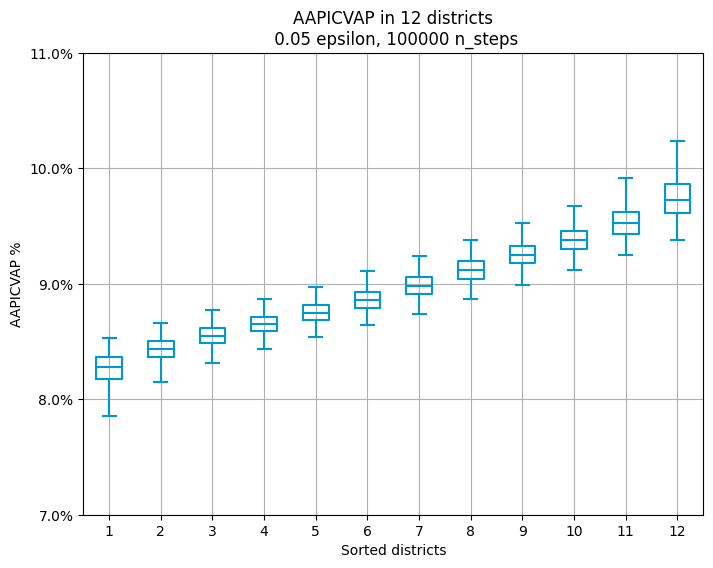

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")
boxstyle = {
        "lw": 1.5 ,
        "color": "#0099cd",
    }
# Draw boxplot
aapi_cvap_df.boxplot(ax=ax, 
           positions=range(len(aapi_cvap_df.columns)),  
           whis=(1,99),
        boxprops=boxstyle,
        whiskerprops=boxstyle,
        capprops=boxstyle,
        medianprops=boxstyle,
        showfliers=False,)

# Annotate
ax.set_title(f"AAPICVAP in {n_districts} districts\n {epsilon} epsilon, {n_steps} n_steps")
ax.set_ylabel("AAPICVAP %")
ax.set_xlabel("Sorted districts")
y_min = 0.07
y_max = .11
ax.set_ylim(y_min,y_max)
ax.set_yticks([x for x in np.arange(y_min,y_max + .01,.01)])
ax.set_yticklabels([f"{x:.1%}" for x in np.arange(y_min,y_max+.01,.01)])
ax.set_xticklabels([x for x in range(1,n_districts+1)])


plt.show()

In [ ]:
# would 30% be enough to get a POC candidate elected
# could do short burst to get as many majority minority as possible?